## SVM

Default LinearSVC achieve worse results than logistic regression. SVC, on the other hand, works good for negative class (0.91) and much worse for positive (0.47), based on averaged cross validation.

Replacing CountVectorizer with TfIdfVectorizer improved averaged CV (0.86 / 0.55). From EDA (TruncatedSGD) it can be seen that it helps to distinguish the targets. Accuracy went up.

Lemmatization didn't help.

In [59]:
%load_ext autoreload
%autoreload 2

import re
import itertools
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [60]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


## Preprocessing

In [61]:
EXTENDED_STRIP_REGEX = r'[!"#$%&()\*\+,-\./:;„”<=>?@\[\\\]^_`{|}~\']'
REMOVE_NUMERICAL = r'[0-9]'

def _preprocessing(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(EXTENDED_STRIP_REGEX, '', txt)
    txt = re.sub(REMOVE_NUMERICAL, '', txt)
    return txt

train_df['text_preproc'] = train_df['text'].apply(_preprocessing)

nlp = spacy.load('en_core_web_sm')

# disable not used parts of pipeline
def _lemma(txt: str) -> str:
    return ' '.join([d.lemma_ for d in nlp(txt)])

train_df['text_preproc'] = train_df['text_preproc'].apply(_lemma)
# train_df['text_preproc']

## Data split

In [62]:
X = train_df['text_preproc']
y = train_df['target']

X[:3]

0    our deed be the reason of this earthquake may ...
1                forest fire near la ronge sask canada
2    all resident ask to shelter in place be be not...
Name: text_preproc, dtype: object

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:3]

4996    courageous and honest analysis of need to use ...
3263    zachzaidman thescore wld b a shame if that gol...
4907    tell barackobama to rescind medal of honor giv...
Name: text_preproc, dtype: object

### Parameter center

In [64]:
VECT_MIN=2
VECT_MAX=0.4

## Vectorization

In [65]:
with open('../resources/stopwords_en.txt', encoding='utf-8') as f:
    stopwords = [line.rstrip() for line in f]

stopwords[:3]

['i', 'me', 'my']

In [66]:
vec = TfidfVectorizer(min_df=VECT_MIN, max_df=VECT_MAX)
vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_test_vec = vec.transform(X_test)

print(vec.get_feature_names())

['aa', 'ab', 'aba', 'abandon', 'abbott', 'abbswinston', 'abc', 'abcnew', 'abcnews', 'abe', 'ability', 'ablaze', 'able', 'abomb', 'abomination', 'abortion', 'about', 'above', 'absolute', 'absolutely', 'abstorm', 'abuse', 'ac', 'accept', 'access', 'accident', 'accidentally', 'accionempresa', 'accord', 'account', 'accuse', 'accustomed', 'acdelco', 'achieve', 'achimota', 'acid', 'acoustic', 'acquire', 'acquisition', 'acre', 'across', 'act', 'action', 'activate', 'active', 'activity', 'actor', 'actual', 'actually', 'acute', 'ad', 'adam', 'add', 'addition', 'address', 'admin', 'admit', 'adult', 'advance', 'advanced', 'adventure', 'advertise', 'advisory', 'af', 'afc', 'affect', 'affiliation', 'afghan', 'afghanistan', 'afp', 'afraid', 'africa', 'african', 'after', 'afterlife', 'afternoon', 'aftershock', 'aftershockdelo', 'ag', 'again', 'against', 'age', 'agency', 'agent', 'ago', 'agree', 'ah', 'ahead', 'ahh', 'ai', 'aid', 'aim', 'air', 'aircraft', 'airline', 'airplane', 'airport', 'ak', 'aka',

In [67]:
svc = SVC()
svc.fit(X_train_vec, y_train)

SVC()

In [68]:
print(svc.score(X_train_vec, y_train))
print(svc.score(X_test_vec, y_test))

0.9545155993431855
0.8069599474720945


[[788  86]
 [208 441]]
Normalized confusion matrix


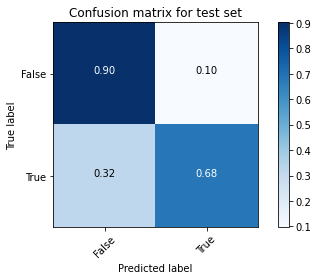

In [69]:
y_pred_test = svc.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred_test)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix for test set',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.print(classification_report(y_test, y_pred_test))
    """
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plot_confusion_matrix(cm, [False, True])

In [70]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.84      0.68      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



## Cross validation

TRAIN: 5709 TEST: 1904
CV ACCURACY: 0.953757225433526


TRAIN: 5710 TEST: 1903
CV ACCURACY: 0.9542907180385289


TRAIN: 5710 TEST: 1903
CV ACCURACY: 0.9562171628721541


TRAIN: 5710 TEST: 1903
CV ACCURACY: 0.9513134851138354


[[3764  578]
 [1485 1786]]
Normalized confusion matrix


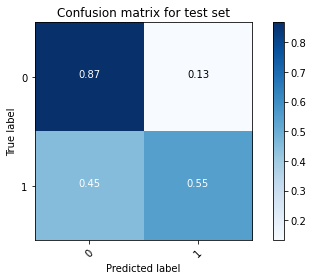

In [71]:
X_cv = train_df['text_preproc']
y_cv = train_df['target']

CONF_MATRIXES = []

skf = StratifiedKFold(n_splits=4)
for train_idx, test_idx in skf.split(X_cv, y_cv):
    print('TRAIN:', len(train_idx), 'TEST:', len(test_idx))
    X_train_cv, X_test_cv = X_cv[train_idx], X_cv[test_idx]
    y_train_cv, y_test_cv = y_cv[train_idx], y_cv[test_idx]

    vec_cv = TfidfVectorizer(min_df=VECT_MIN, max_df=VECT_MAX)
    X_train_vec_cv = vec_cv.fit_transform(X_train_cv)
    X_test_vec_cv = vec_cv.transform(X_test_cv)

    svc_cv = SVC()
    svc_cv.fit(X_train_vec_cv, y_train_cv)
    accuracy_cv = svc_cv.score(X_train_vec_cv, y_train_cv)

    print(f'CV ACCURACY: {accuracy_cv}')
    y_pred_cv = svc_cv.predict(X_test_vec_cv)
    cm = confusion_matrix(y_test_cv, y_pred_cv)
    CONF_MATRIXES.append(cm)
    print('\n')

# overall results
cm = np.array(CONF_MATRIXES).sum(axis=0)
plot_confusion_matrix(cm, [0, 1])

## Final model training

0.9500853802705898
[[4280   62]
 [ 318 2953]]
Normalized confusion matrix
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4342
           1       0.98      0.90      0.94      3271

    accuracy                           0.95      7613
   macro avg       0.96      0.94      0.95      7613
weighted avg       0.95      0.95      0.95      7613



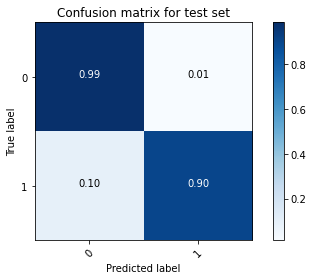

In [72]:
vec = TfidfVectorizer(min_df=VECT_MIN, max_df=VECT_MAX)
X_vec = vec.fit_transform(X)

svc = SVC()
svc.fit(X_vec, y)
print(svc.score(X_vec, y))

y_pred = svc.predict(X_vec)

cm = confusion_matrix(y, svc.predict(X_vec))
plot_confusion_matrix(cm, [0, 1])

print(classification_report(y, y_pred))

In [73]:
test_df[:3]

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [74]:
test_df['text_preproc'] = test_df['text'].apply(_preprocessing)
X_out = test_df['text_preproc']
X_out

0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4             typhoon soudelor kills  in china and taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety faste...
3259    storm in ri worse than last hurricane my citya...
3260    green line derailment in chicago httptcoutbxlc...
3261    meg issues hazardous weather outlook hwo httpt...
3262    cityofcalgary has activated its municipal emer...
Name: text_preproc, Length: 3263, dtype: object

In [75]:
X_out_vec = vec.transform(X_out)
X_out_vec

<3263x5423 sparse matrix of type '<class 'numpy.float64'>'
	with 29177 stored elements in Compressed Sparse Row format>

In [76]:
y_out_pred = svc.predict(X_out_vec)
y_out_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [77]:
file = pd.DataFrame({
   'id': test_df['id'],
   'target': y_out_pred
})

file.to_csv('disaster-tweets-svm-tfidf-lemma.csv', index=False)